In [154]:
# importing all required libraries

import PyPDF2
import docx2txt
import os
import pandas as pd
from collections import Counter
import en_core_web_sm
from docx import Document
nlp = en_core_web_sm.load()
from spacy.matcher import PhraseMatcher
import io
from io import StringIO
from pathlib import Path

import matplotlib.pyplot as plt

In [155]:
#reads texts from Word docs
 
def extract_text_from_docx(file):
    doc = Document(file)
    return ' '.join([paragraph.text for paragraph in doc.paragraphs])
    

In [185]:
from PyPDF2 import PdfReader


def pdfextract(file):
    with open(file, 'rb') as pdf_file:
        pdf_reader = PdfReader(pdf_file)
        text = [pdf_reader.pages[count].extract_text() for count in range(len(pdf_reader.pages))]
    return ' '.join(text)

In [189]:


def clean_and_tokenize(text):
    return nlp(' '.join(char.lower() for char in text if char.isalpha() or char.isspace()))


def extract_text(file):
    if file.endswith('.docx'):
        return extract_text_from_docx(file)
    elif file.endswith('.pdf'):
        return pdfextract(file)
    elif file.endswith('.csv'):
        return ''
    else:
        raise ValueError("Unsupported file format")


def create_profile(file):
    text = extract_text(file)
    text = str(text)
    text = text.replace("\\n", "")
    text = text.lower()

    # below is the csv where we have all the keywords, you can customize your own
    keyword_dict = pd.read_csv('D:/Documents/resumes/template_new.csv')
    stats_words = [nlp(text) for text in keyword_dict['Statistics '].dropna(axis=0)]
    NLP_words = [nlp(text) for text in keyword_dict['NLP'].dropna(axis=0)]
    ML_words = [nlp(text) for text in keyword_dict['Machine Learning'].dropna(axis=0)]
    DL_words = [nlp(text) for text in keyword_dict['Deep Learning'].dropna(axis=0)]
    R_words = [nlp(text) for text in keyword_dict['R Language'].dropna(axis=0)]
    python_words = [nlp(text) for text in keyword_dict['Python Language'].dropna(axis=0)]
    Data_Engineering_words = [nlp(text) for text in keyword_dict['Data Engineering'].dropna(axis=0)]

    matcher = PhraseMatcher(nlp.vocab)
    matcher.add('Stats', None, *stats_words)
    matcher.add('NLP', None, *NLP_words)
    matcher.add('ML', None, *ML_words)
    matcher.add('DL', None, *DL_words)
    matcher.add('R', None, *R_words)
    matcher.add('Python', None, *python_words)
    matcher.add('DE', None, *Data_Engineering_words)
    doc = nlp(text)

    d = []
    matches = matcher(doc)
    for match_id, start, end in matches:
        rule_id = nlp.vocab.strings[match_id]  # get the unicode ID, i.e. 'COLOR'
        span = doc[start: end]  # get the matched slice of the doc
        d.append((rule_id, span.text))
    keywords = "\n".join(f'{i[0]} {i[1]} ({j})' for i, j in Counter(d).items())

    ## converting string of keywords to dataframe
    df = pd.read_csv(StringIO(keywords), names=['Keywords_List'])
   # df1 = pd.DataFrame(df.Keywords_List.str.split(' ', 1).tolist(), columns=['Subject', 'Keyword'])
    
    df1 = pd.DataFrame(df.Keywords_List.apply(lambda x: x.split(' ', 1) if isinstance(x, str) else [x, '']).tolist(), columns=['Subject', 'Keyword'])

    
   # df2 = pd.DataFrame(df1.Keyword.str.split('(', 1).tolist(), columns=['Keyword', 'Count'])
    
    df2 = pd.DataFrame(df1.Keyword.apply(lambda x: x.split('(', 1) if isinstance(x, str) else [x, '']).tolist(), columns=['Keyword', 'Count'])

    df3 = pd.concat([df1['Subject'], df2['Keyword'], df2['Count']], axis=1)
    df3['Count'] = df3['Count'].apply(lambda x: x.rstrip(")"))

    base = os.path.basename(file)
    filename = os.path.splitext(base)[0]

    name = filename.split('_')
    name2 = name[0]
    name2 = name2.lower()
    ## converting str to dataframe
    name3 = pd.read_csv(StringIO(name2), names=['Candidate Name'])

    dataf = pd.concat([name3['Candidate Name'], df3['Subject'], df3['Keyword'], df3['Count']], axis=1)
    dataf['Candidate Name'].fillna(dataf['Candidate Name'].iloc[0], inplace=True)

    return (dataf)


In [190]:
# connect path to dir where resumes are stored
mypath = 'D:/Documents/resumes'
onlyfiles = [os.path.join(mypath, f) for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]


In [191]:
#code to execute/call the above functions

final_database = pd.DataFrame()
for file in onlyfiles:
    dat = create_profile(os.path.join(mypath, file))
    #final_database = final_database.append(dat)
    final_database = pd.concat([final_database, dat], ignore_index=True)


print(final_database)






    Candidate Name Subject           Keyword Count
0          rosacho  Python           python      3
1          rosacho      DE              sql      1
2          rosacho     NLP              nlp      3
3          rosacho  Python           pandas      1
4          rosacho      DL           opencv      1
..             ...     ...               ...   ...
172        rosacho  Python           pandas      1
173        rosacho  Python            numpy      1
174        rosacho      DL  computer vision      1
175        rosacho      DL   neural network      1
176       template     NaN               NaN   NaN

[177 rows x 4 columns]


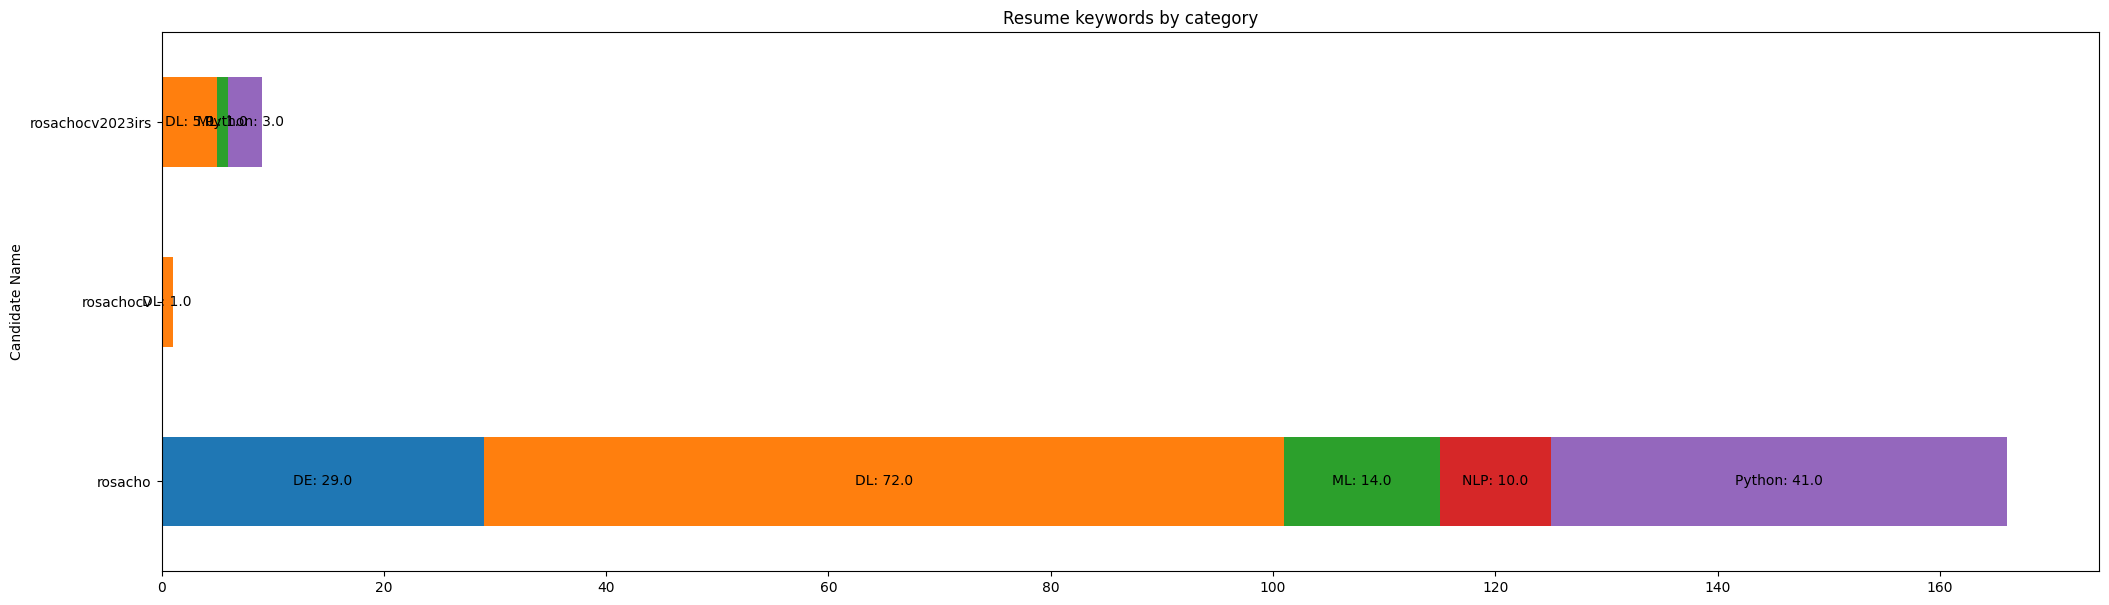

In [192]:
#code to count words under each category and visulaize it through Matplotlib

final_database2 = final_database['Keyword'].groupby([final_database['Candidate Name'], final_database['Subject']]).count().unstack()
final_database2.reset_index(inplace = True)
final_database2.fillna(0,inplace=True)
new_data = final_database2.iloc[:,1:]
new_data.index = final_database2['Candidate Name']
#execute the below line if you want to see the candidate profile in a csv format
#sample2=new_data.to_csv('sample.csv')
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
ax = new_data.plot.barh(title="Resume keywords by category", legend=False, figsize=(25,7), stacked=True)
labels = []
for j in new_data.columns:
    for i in new_data.index:
        label = str(j)+": " + str(new_data.loc[i][j])
        labels.append(label)
patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
        ax.text(x + width/2., y + height/2., label, ha='center', va='center')
plt.show()